# Q-Learning for a Wind Turbine Yaw Alignment to Maximize Power Production

This is a sample program for executing the Q-Learning algorithm to find the best nacelle angle in terms of power production.

*   The wind direction and nacelle angle are states of the system and change in the nacelle angle is the action. The states and actions are discretized to adapt to q-Learning algorithm requirements.

*   A simple model for the power production (reward) is adopted which returns the cosine of the difference between the actual wind direction and the nacelle angle. A fully random method is used for generating actions at each training step. 

*   The Q matrix is filled by the Q of the current state and action, estimation of the best Q for the next step, and the reward value. 

*   In the training phase, the Q matrix is filled in a loop through random sampling of the states and action.

*   For the test, the process starts with a desired initial state, and then the actions are chosen based on the corresponding largest Q value. 



In [3]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib
from tqdm import tqdm 

# States Definition
wind_dir = np.linspace(-90,80,18)
Nacelle_ang = np.linspace(-90,80,18)

# Action Definition
actions = np.array([-10,0,+10])

# R matrix
A = np.array(list(itertools.product(wind_dir, Nacelle_ang,actions)))
table = pd.DataFrame({'wind_dir': A[:,0],'Nacelle_ang': A[:,1], 'action': A[:,2]})

#Removing Infeasible Action-State Rows
table.drop(table[(table['wind_dir'] - table['Nacelle_ang'] == -90) & (table['action'] == 10)].index, inplace = True)
table.drop(table[(table['wind_dir'] - table['Nacelle_ang'] ==  90) & (table['action'] == -10)].index, inplace = True)

# Reward Function Generation
def rewardFunc(row):
    return np.cos((row['wind_dir'] - (row['Nacelle_ang'] + row['action']))*np.pi/180)

# Function to Move to the Next State by the Input Action
def statePropagation(state, action):
    return(state[0] , state[1] + action)

# Reward Table    
table['reward'] = table.apply(lambda row: rewardFunc(row), axis = 1)
R_table = pd.pivot_table(table, values='reward', index=['wind_dir' , 'Nacelle_ang'],
                    columns=['action'], aggfunc=np.sum)

# Q matrix
Q = pd.DataFrame(0, index = R_table.index, columns = R_table.columns)

# Gamma and Alpha (learning parameter).
gamma = 0.4
alpha = 0.9

# Function to Identify Possible Actions
def available_actions(state):
    current_state_row = R_table.loc[state]
    av_act = ~np.isnan(current_state_row.values)
    av_act = actions[av_act]
    return av_act.astype(int)

# Training Loop to Fill the Q Matrix
for i in tqdm(range(20000)):
    current_state = np.random.choice(R_table.index,1, replace = False)
    available_act = available_actions(current_state[0])
    action = np.random.choice(available_act)
    next_state = statePropagation(current_state[0] ,action)
    Q_next_max = np.max(Q.loc[current_state].values)
    Q.loc[current_state, action] = Q.loc[current_state, action] + alpha * (R_table.loc[current_state,action] + gamma * Q_next_max - Q.loc[current_state, action])
    
Q.head(10)

action                   -10.0      0.0       10.0
wind_dir Nacelle_ang                              
-90.0    -90.0        1.651474  1.666667  1.651474
         -80.0        1.666667  1.651474  1.606359
         -70.0        1.641345  1.596230  1.522561
         -60.0        1.566154  1.492487  1.392506
         -50.0        1.443375  1.343395  1.220138
         -40.0        1.276741  1.153484  1.010696
         -30.0        1.071313  0.928525  0.770544
         -20.0        0.833333  0.675353  0.506982
         -10.0        0.570034  0.401662  0.228013
          0.0         0.289414  0.115765  0.000000

In [12]:
# Initial State
states = [(-90, 80)]

# Determining the States and Action Sequence
episodes = range(20)
action_sequence = []
for i in episodes:
    next_step_index = np.where(Q.loc[states[-1]].values == np.max(Q.loc[states[-1]].values))[0]
    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size = 1))
    else:
        next_step_index = int(next_step_index)
    av_act = actions[next_step_index]
    next_state = statePropagation(states[-1],av_act)
    states.append(next_state)
    action_sequence.append(av_act)

print('State Sequence:        ')
print(states)
print('\nAction Sequence:        ')
print(action_sequence)

State Sequence:        
[(-90, 80), (-90, 70), (-90, 60), (-90, 50), (-90, 40), (-90, 30), (-90, 20), (-90, 10), (-90, 0), (-90, -10), (-90, -20), (-90, -30), (-90, -40), (-90, -50), (-90, -60), (-90, -70), (-90, -80), (-90, -90), (-90, -90), (-90, -90), (-90, -90)]

Action Sequence:        
[-10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, 0, 0, 0]


Text(0, 0.5, 'Action (deg)')

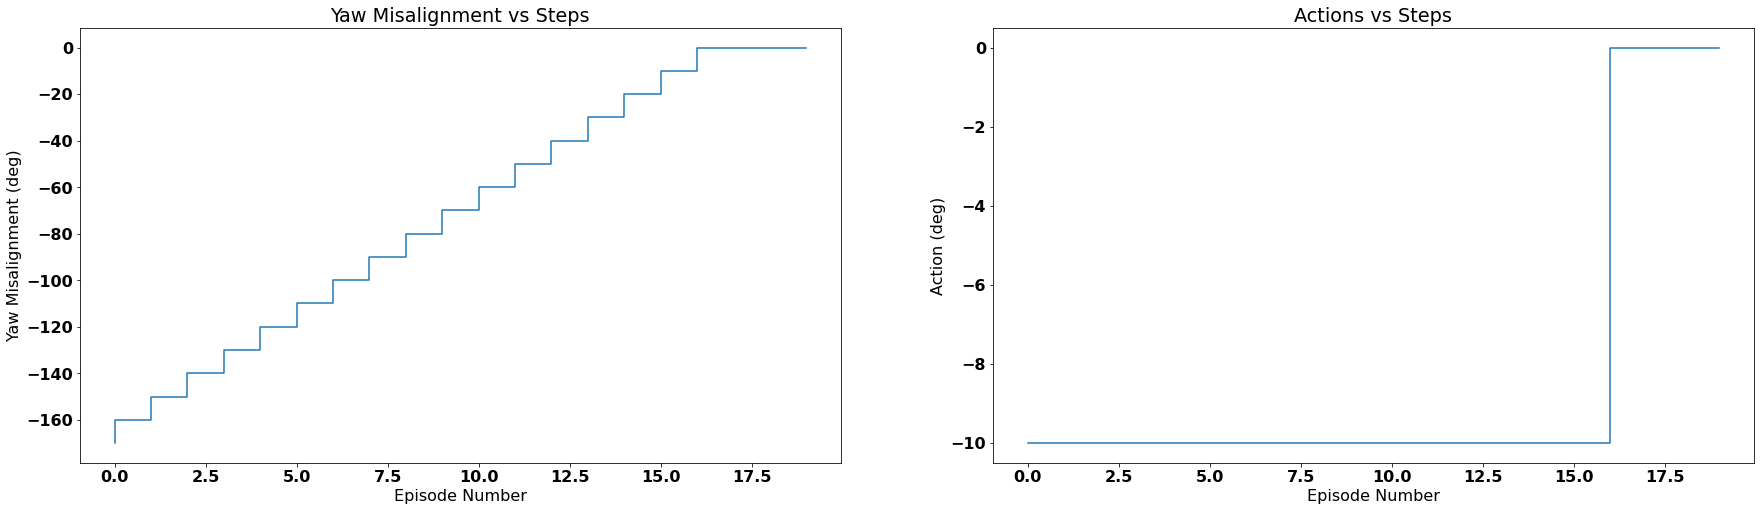

In [11]:
font = {'size'   : 16}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(1,2, figsize = (30,8))
ax[0].step(episodes, [s[0] - s[1] for s in states[:-1]])
ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_title('Yaw Misalignment vs Steps')
ax[0].set_xlabel('Episode Number')
ax[0].set_ylabel('Yaw Misalignment (deg)')

ax[1].step(episodes, action_sequence)
ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_title('Actions vs Steps')
ax[1].set_xlabel('Episode Number')
ax[1].set_ylabel('Action (deg)')